In [1]:
from common import colors, sbarlw, insetlw, savefig

In [2]:
import os
os.chdir(os.path.join('..', '..'))
print(os.getcwd())

/home/efharkin/projects/raphegif/raphegif


In [3]:
from __future__ import division, print_function

import re

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from ezephys import pltools
from ezephys.rectools import ABFLoader
from grr.cell_class import preprocess_recording
from grr.Tools import dashedBorder, timeToIndex

In [4]:
NOTEBOOK_PATH = os.path.join('figs', 'scripts')

plt.style.use(os.path.join(NOTEBOOK_PATH, 'publication_figure_style.dms'))

In [5]:
PHARM_DATA_PATH = os.path.join(
    os.getenv('DATA_PATH'), 'raw', '5HT', 'heated_pharmacology',
)
rec_index = pd.read_csv(
    os.path.join(PHARM_DATA_PATH, 'index.csv'), comment='#',
)
rec_index

,cell_id,membrane_resistance_megaohm,membrane_capacitance_picofarad,access_resistance_megaohm,holding_current_picoamp,filename,comment,include
0,DRN1127,400,50,18,NaN,22422001.abf,Wash-in,True
1,DRN1127,400,50,18,NaN,22422005.abf,Wash-out,True
2,DRN1127,400,50,18,NaN,22422006.abf,Wash-out continued,True
3,DRN1128,400,60,21,NaN,22422008.abf,Wash-in,True
4,DRN1128,400,60,21,NaN,22422010.abf,"Wash-out, unclamped action potentials",False


In [6]:
def load_recs_by_cell_id(cell_id):
    fnames_and_comments = rec_index.query('cell_id == @cell_id and include').loc[
        :, ['filename', 'comment']
    ]

    # Sort recordings according to last three digits of filename, which
    # indicate the order in which they were recorded.
    pat = re.compile('\d{2}[0-9ond]\d{2}(\d{3})\.abf')
    order = np.argsort(
        [
            int(pat.search(fname).groups()[0])
            for fname in fnames_and_comments['filename']
        ]
    )
    print('Recordings loaded in the following order:\n- ', end='')
    print('\n- '.join(fnames_and_comments.reset_index(drop=True)['comment'][order]))

    sorted_fnames = fnames_and_comments.reset_index(drop=True).loc[
        order, 'filename'
    ]
    l = ABFLoader()
    recordings = l.load(
        [os.path.join(PHARM_DATA_PATH, fname) for fname in sorted_fnames]
    )

    # Generate diagnostic plots of recordings
    for r in recordings:
        r.plot()
        plt.gcf().clf()
        plt.close(plt.gcf())

    return recordings


def time_window_plot(recordings, peak_window):
    for r in recs:
        f, axes = plt.subplots(1, 2)
        axes[0].plot(r.time_supp, r[0, ...], 'k-', alpha=0.8)
        axes[0].set_xlim(0, 1000)
        axes[0].set_ylim(-250, 300)

        axes[1].plot(r.time_supp, r[0, ...], 'k-', alpha=0.8)
        axes[1].set_xlim(4300, 4500)
        axes[1].set_ylim(-250, 750)
        axes[1].axvspan(*(peak_range * r.dt))
        plt.show()
        f.clf()
        plt.close(f)


def extract_peak_current(recordings, peak_window, sweep_interval, ax=None):
    """Extract the amplitude of the A-type current over time.

    Parameters
    ----------
    recordings: [Recording]
    peak_window: [int, int]
        Time interval in timesteps to measure the amplitude of the current.
    sweep_interval: float
        Time in seconds between each recording sweep.
    ax: Optional[matplotlib.Axes]
        Axes on which to plot peak current over time. No plot is produced if 
        None.

    Returns
    -------
    (np.ndarray[time_stamp], np.ndarray[current_amplitude])
        Time stampe are in minutes and current amplitude is in nA (baseline- 
        and leak-subtracted).

    """
    peak_window = np.asarray(peak_window)
    baseline_slice = slice(0, 4000)
    test_slice = slice(12000, 15000)
    current_channel = 0

    peak_current = []
    for r in recs:
        peak_current.extend(
            preprocess_recording(
                r, baseline_slice, test_slice, current_channel=current_channel
            )[current_channel, slice(*peak_range), :].mean(axis=0)
        )
        # Append NaN to indicate break in recording
        peak_current.append(np.nan)

    time = np.arange(len(peak_current)) / (60. / sweep_interval)
    peak_current = np.array(peak_current) * 1e-3

    if ax is not None:
        ax.plot(time, peak_current, 'k-')
        annotation_baseline = np.nanmax(peak_current) * 1.1
        ax.plot(
            [0, recs[0].shape[2] / (60. / sweep_interval)],
            [annotation_baseline, annotation_baseline],
            'k-',
            lw=2,
        )
        ax.text(
            recs[0].shape[2] / (60. / sweep_interval * 2.0),
            annotation_baseline * 1.05,
            'HpTx-2 \n+ AmmTx-3',
            fontsize='small',
            ha='center',
        )
        ax.set_ylabel('Peak current amplitude (nA)')
        ax.set_xlabel('Time (min)')
        pltools.hide_border('tr', trim=True, ax=ax)

    return time, peak_current

## First neuron

the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release


Recordings loaded in the following order:
- Wash-in
- Wash-out
- Wash-out continued


the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release


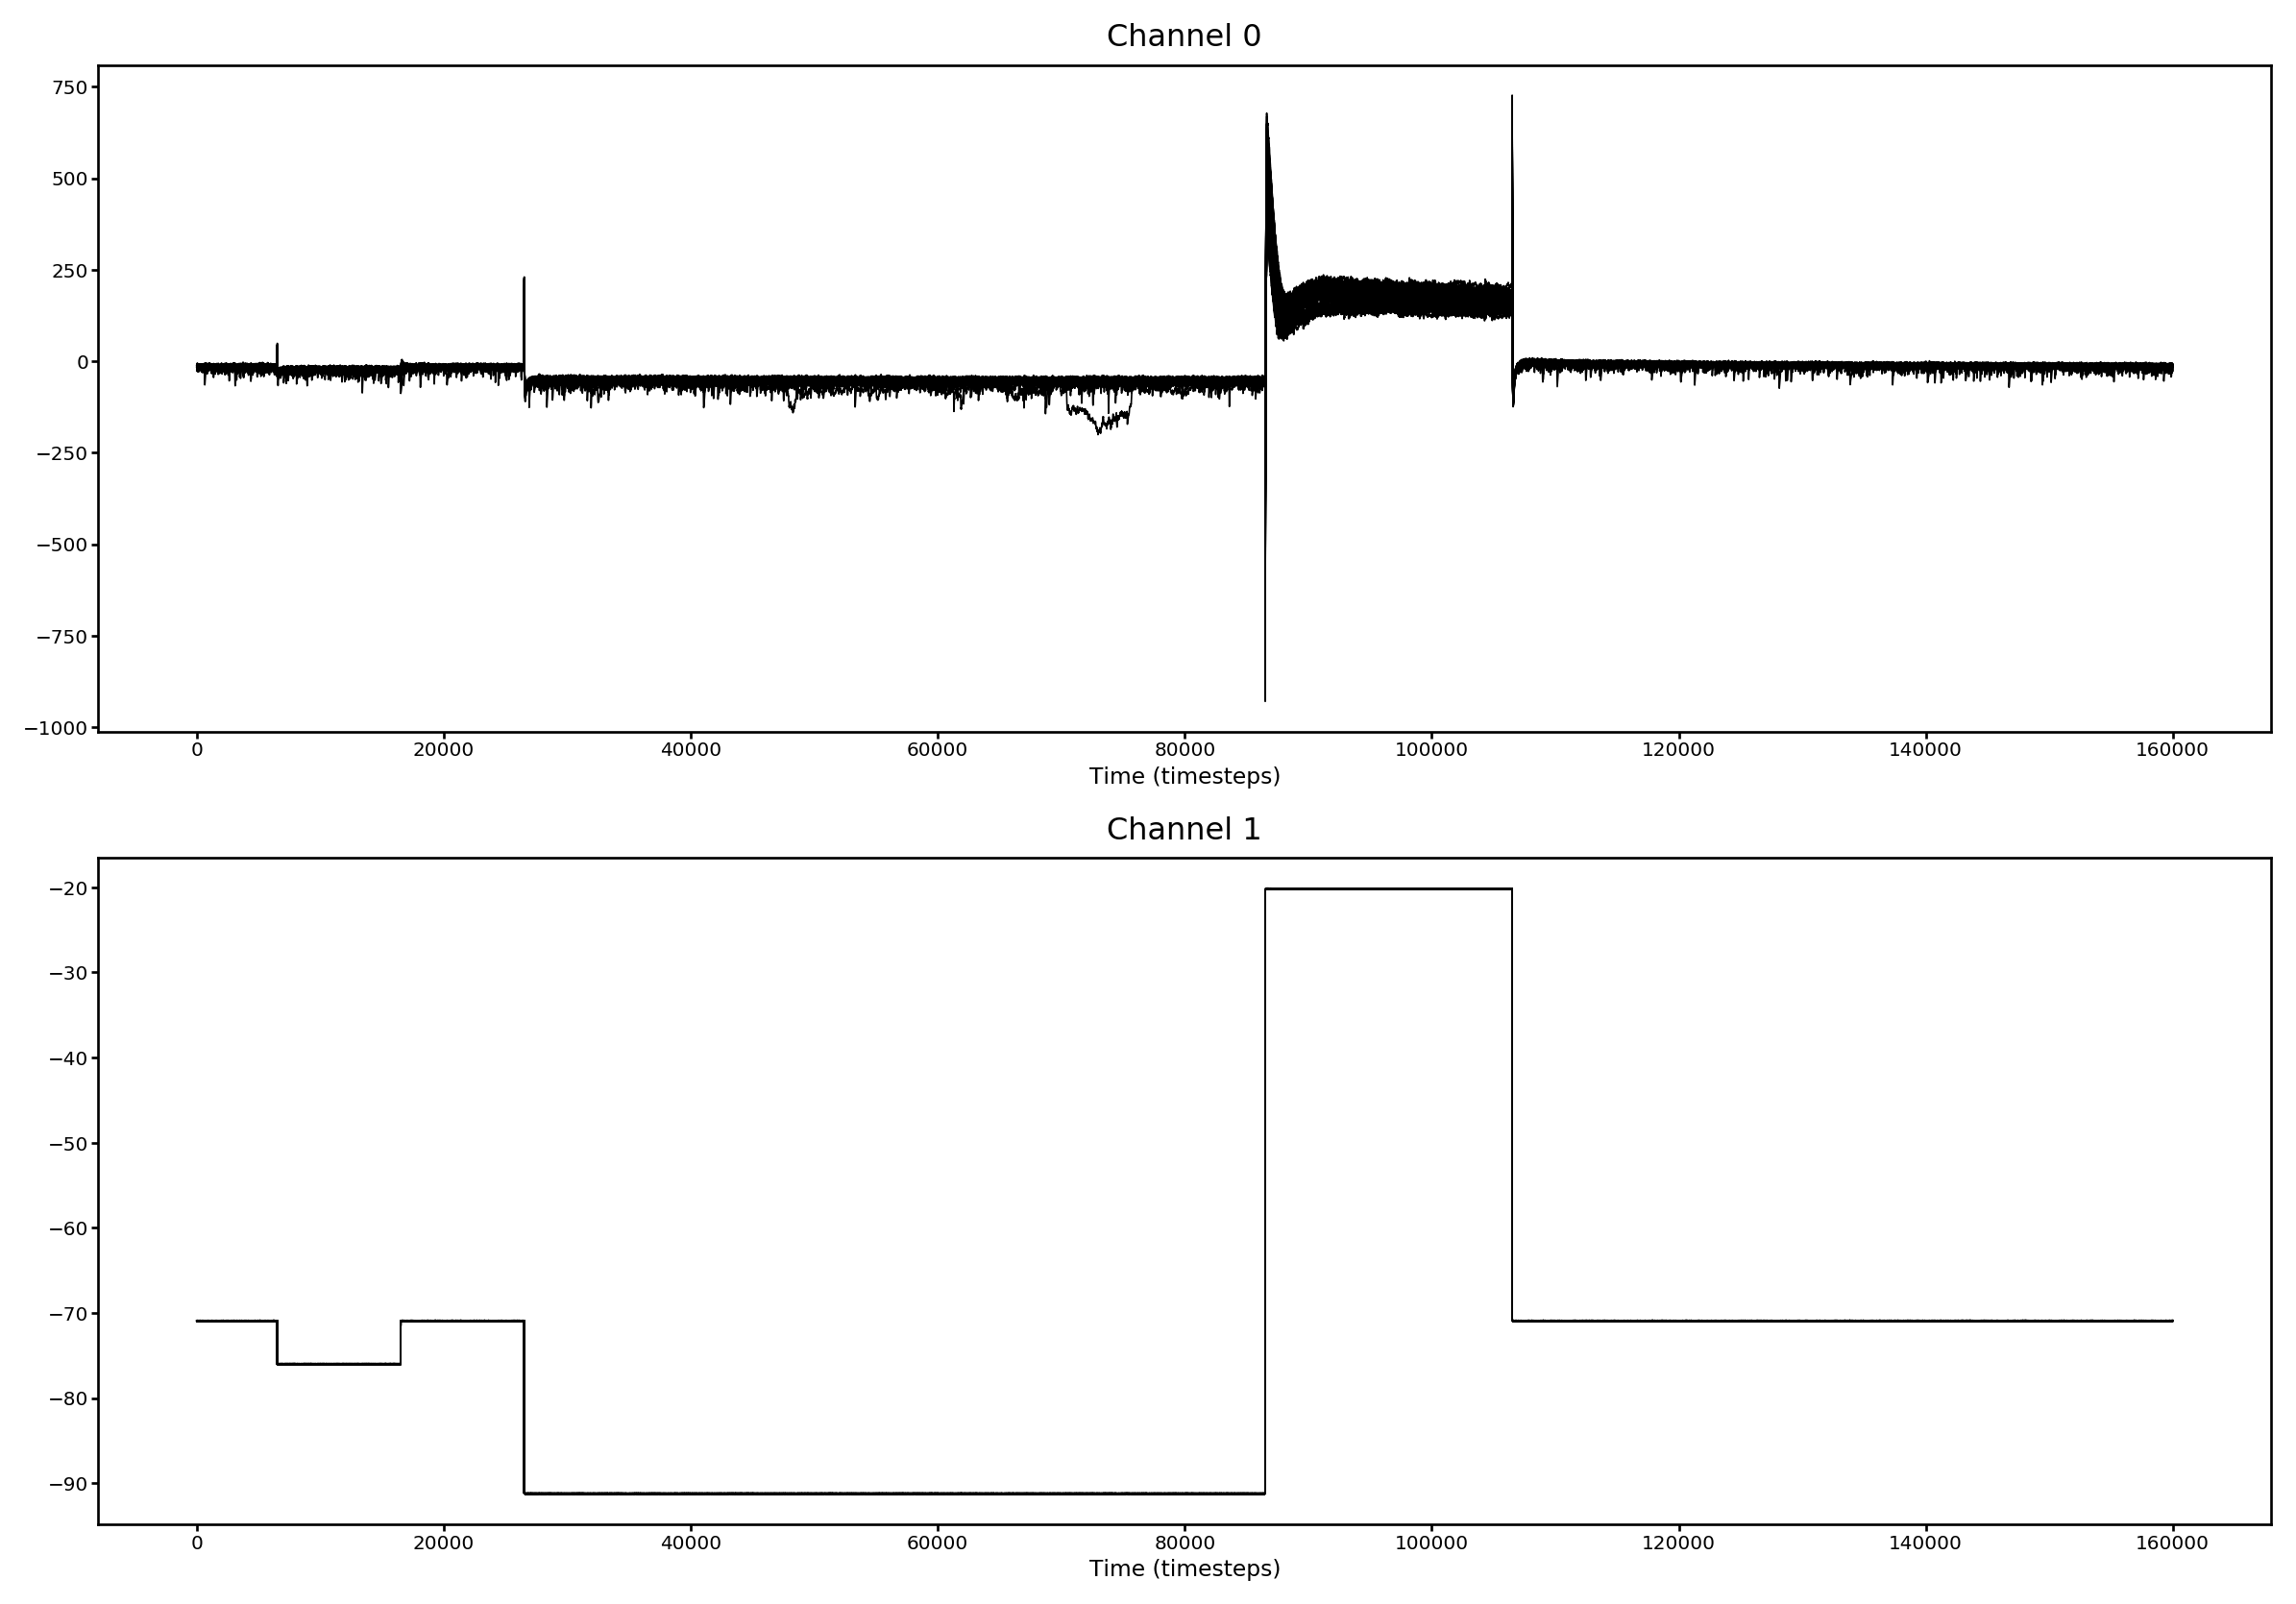

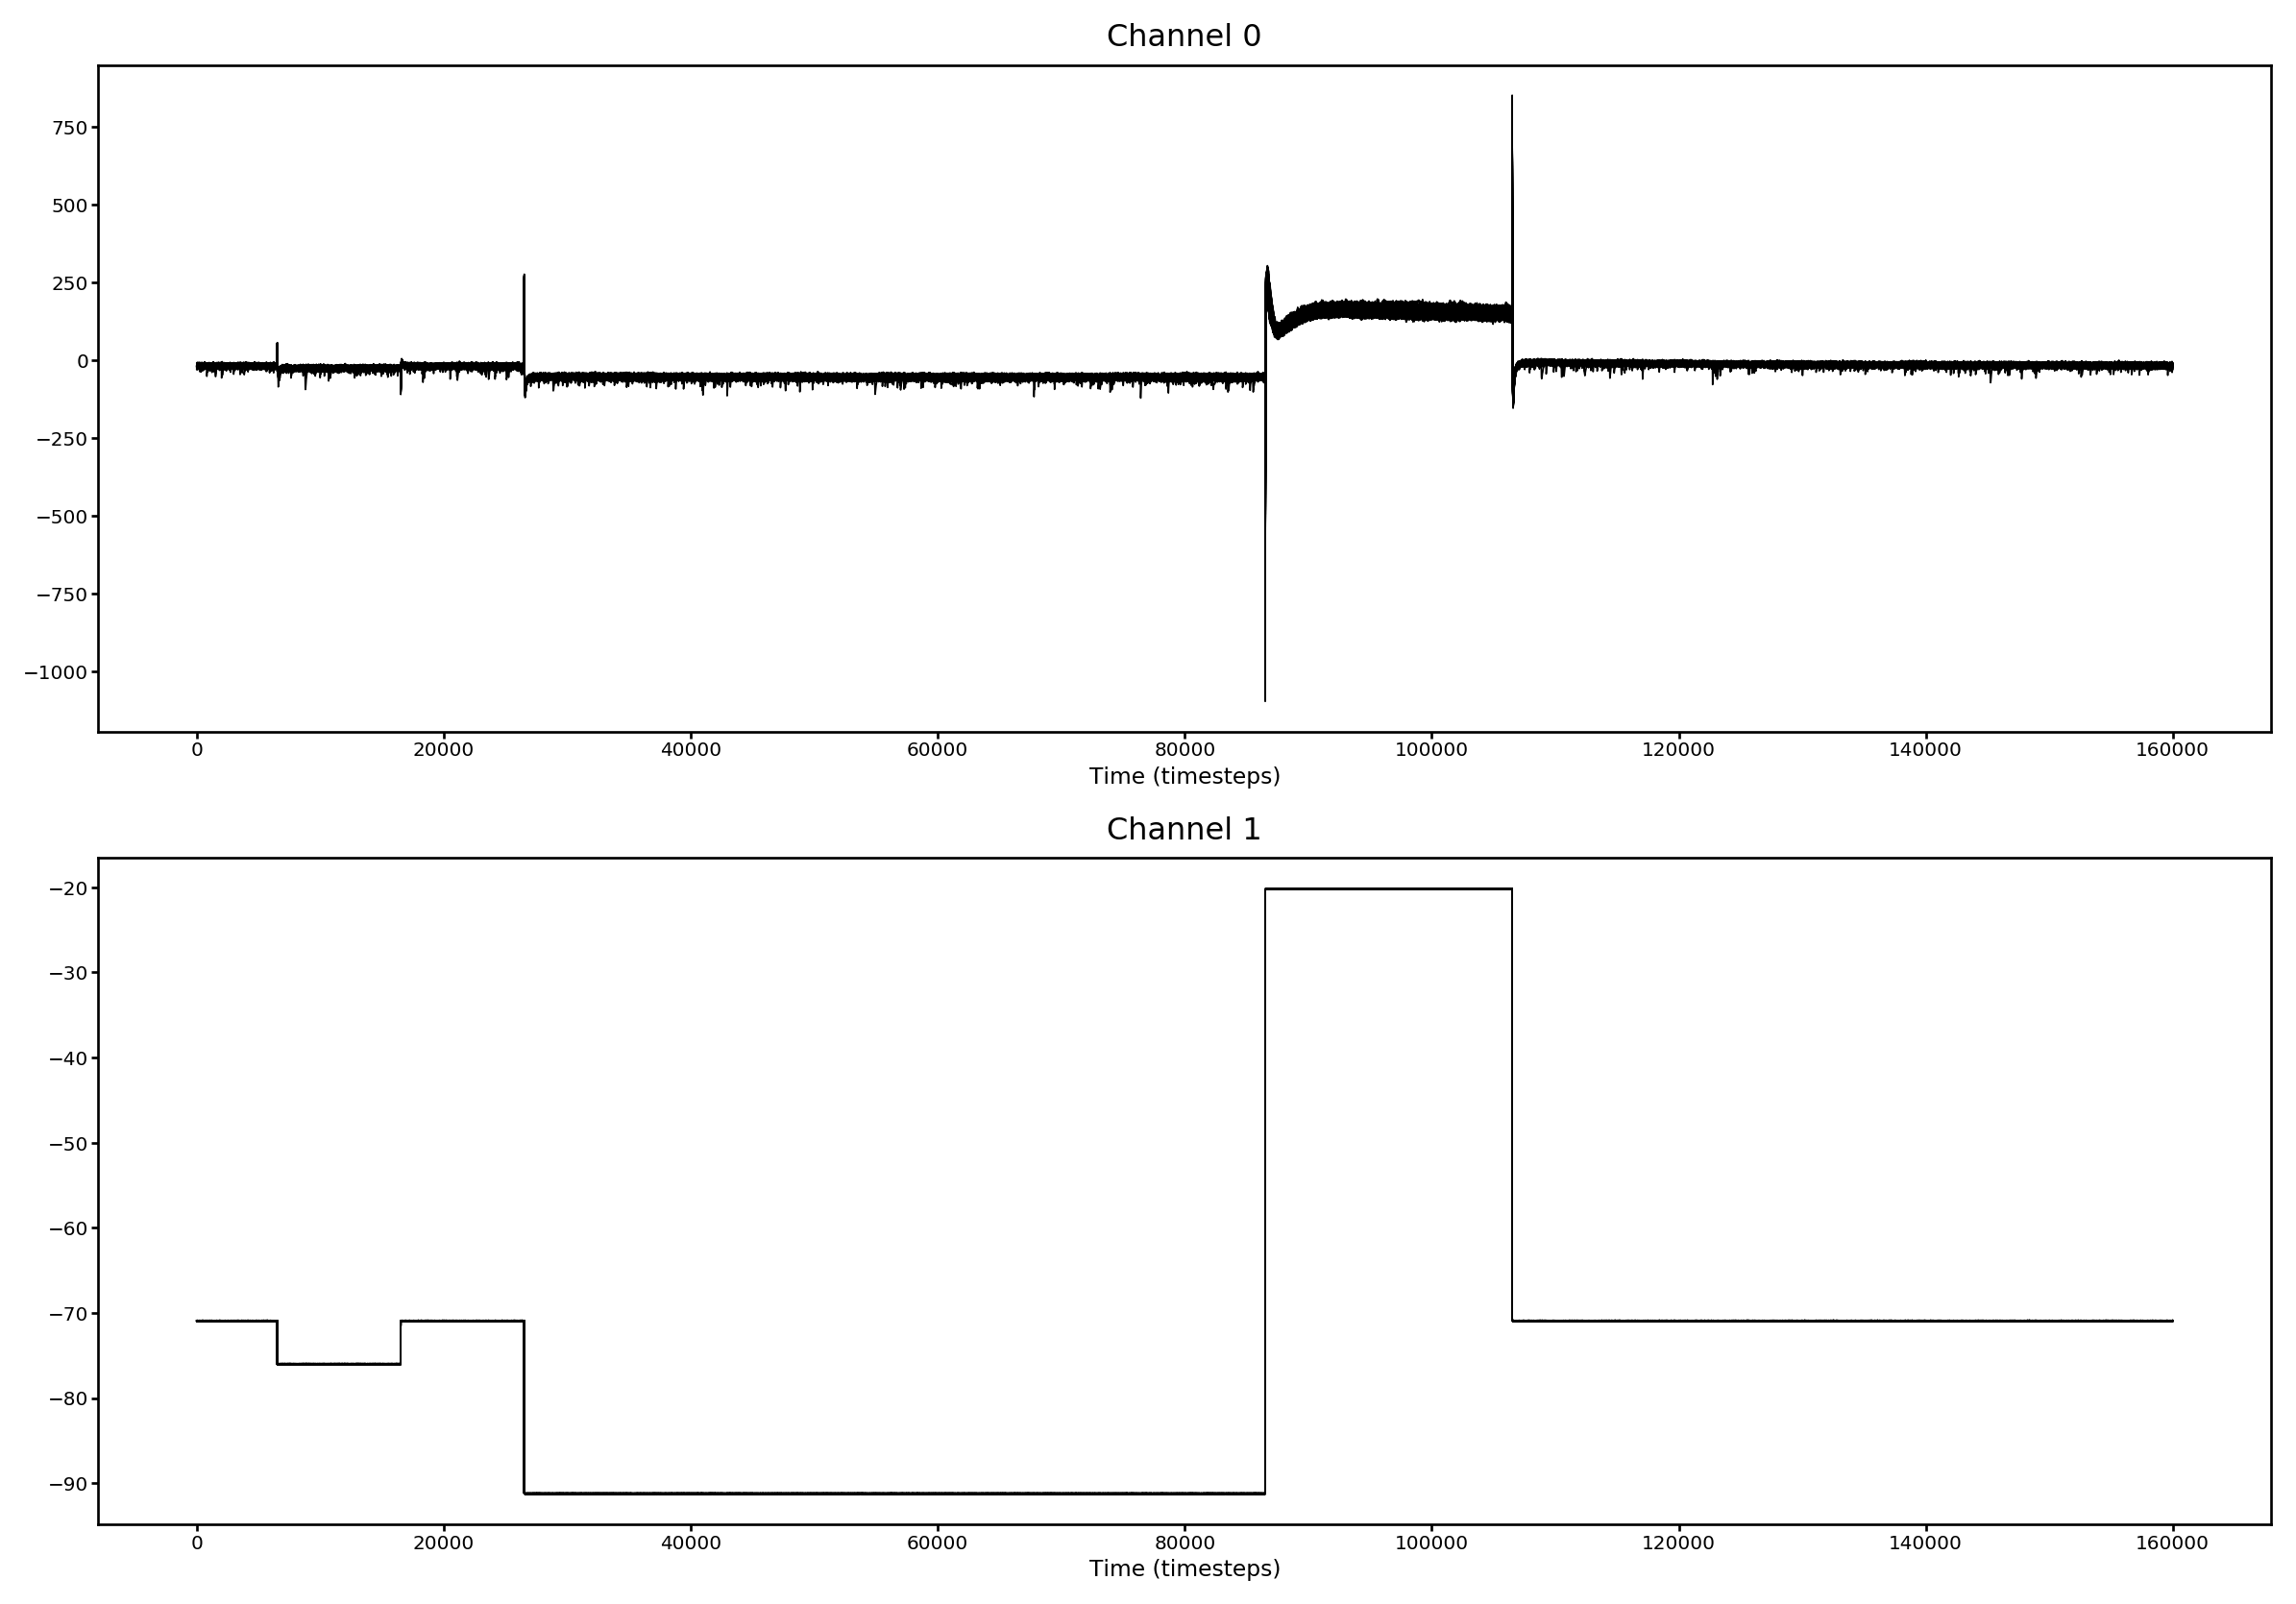

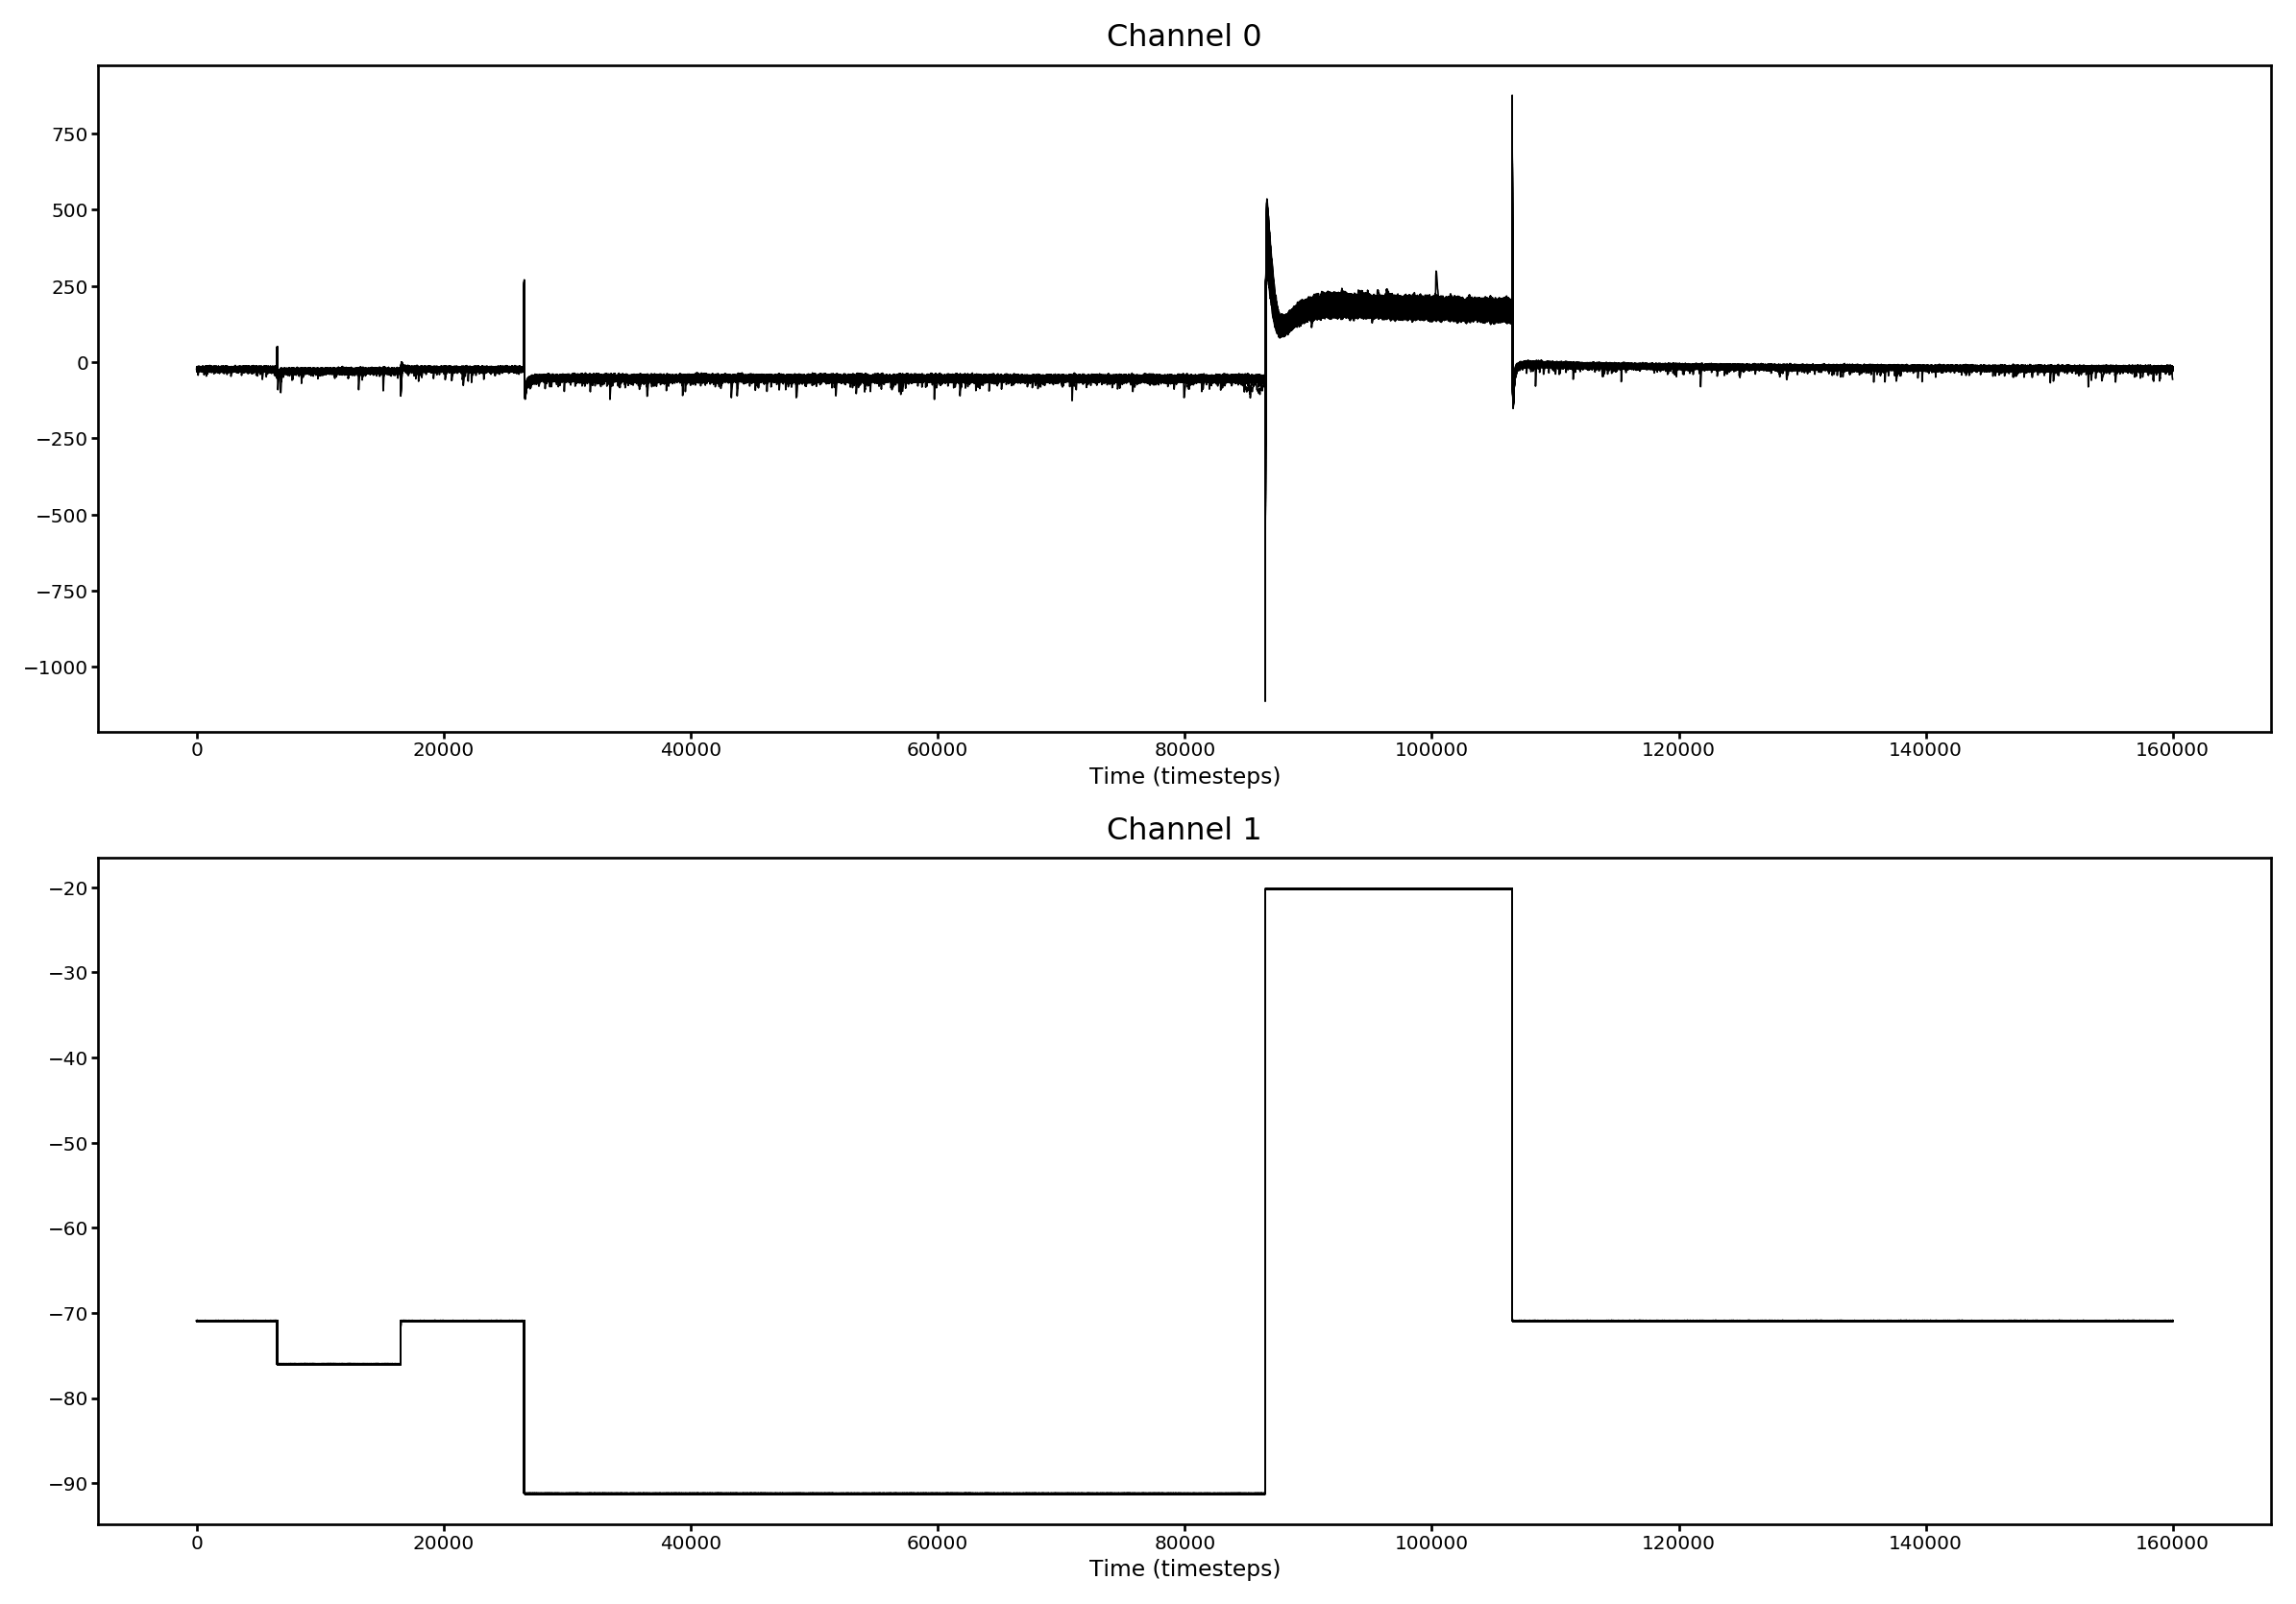

In [7]:
recs = load_recs_by_cell_id('DRN1127')

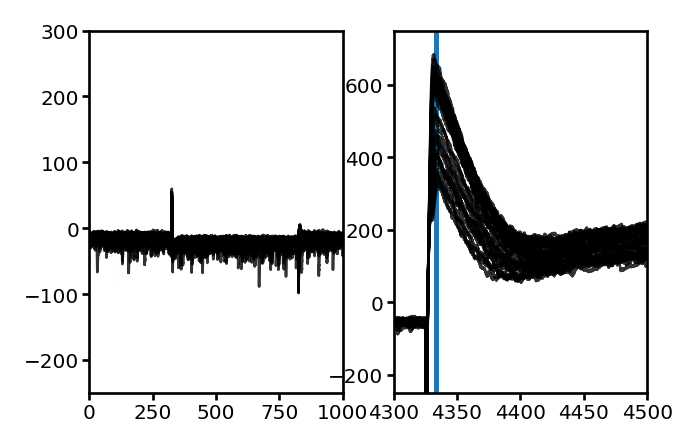

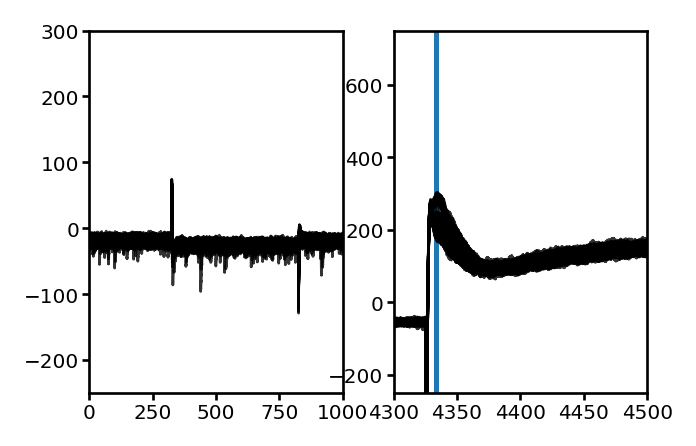

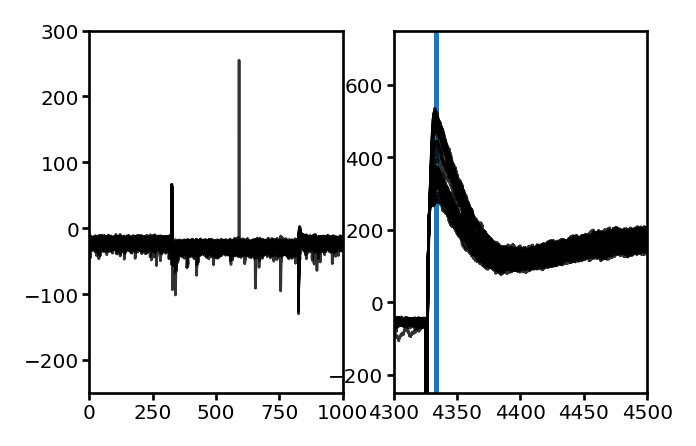

In [8]:
peak_range = np.array([86640, 86720])
time_window_plot(recs, peak_range)

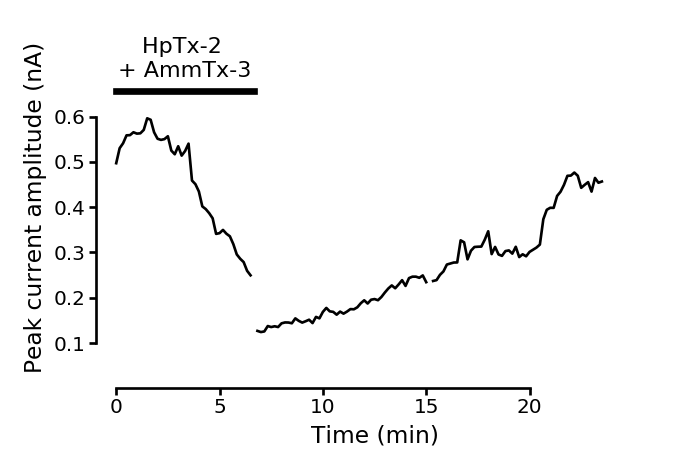

In [9]:
fig, ax = plt.subplots(1, 1)
extract_peak_current(recs, peak_range, 10., ax)
ax.set_ylim(0, 0.8)
ax.set_xlim(-1, 26)
plt.savefig(
    os.path.join(
        os.getenv('IMG_PATH'), 
        'ser_ia_pharmacology_heated_time_course_{}'.format('DRN1127')
    )
)
plt.show()
fig.clf()
plt.close(fig)

## Second neuron

the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release


Recordings loaded in the following order:
- Wash-in


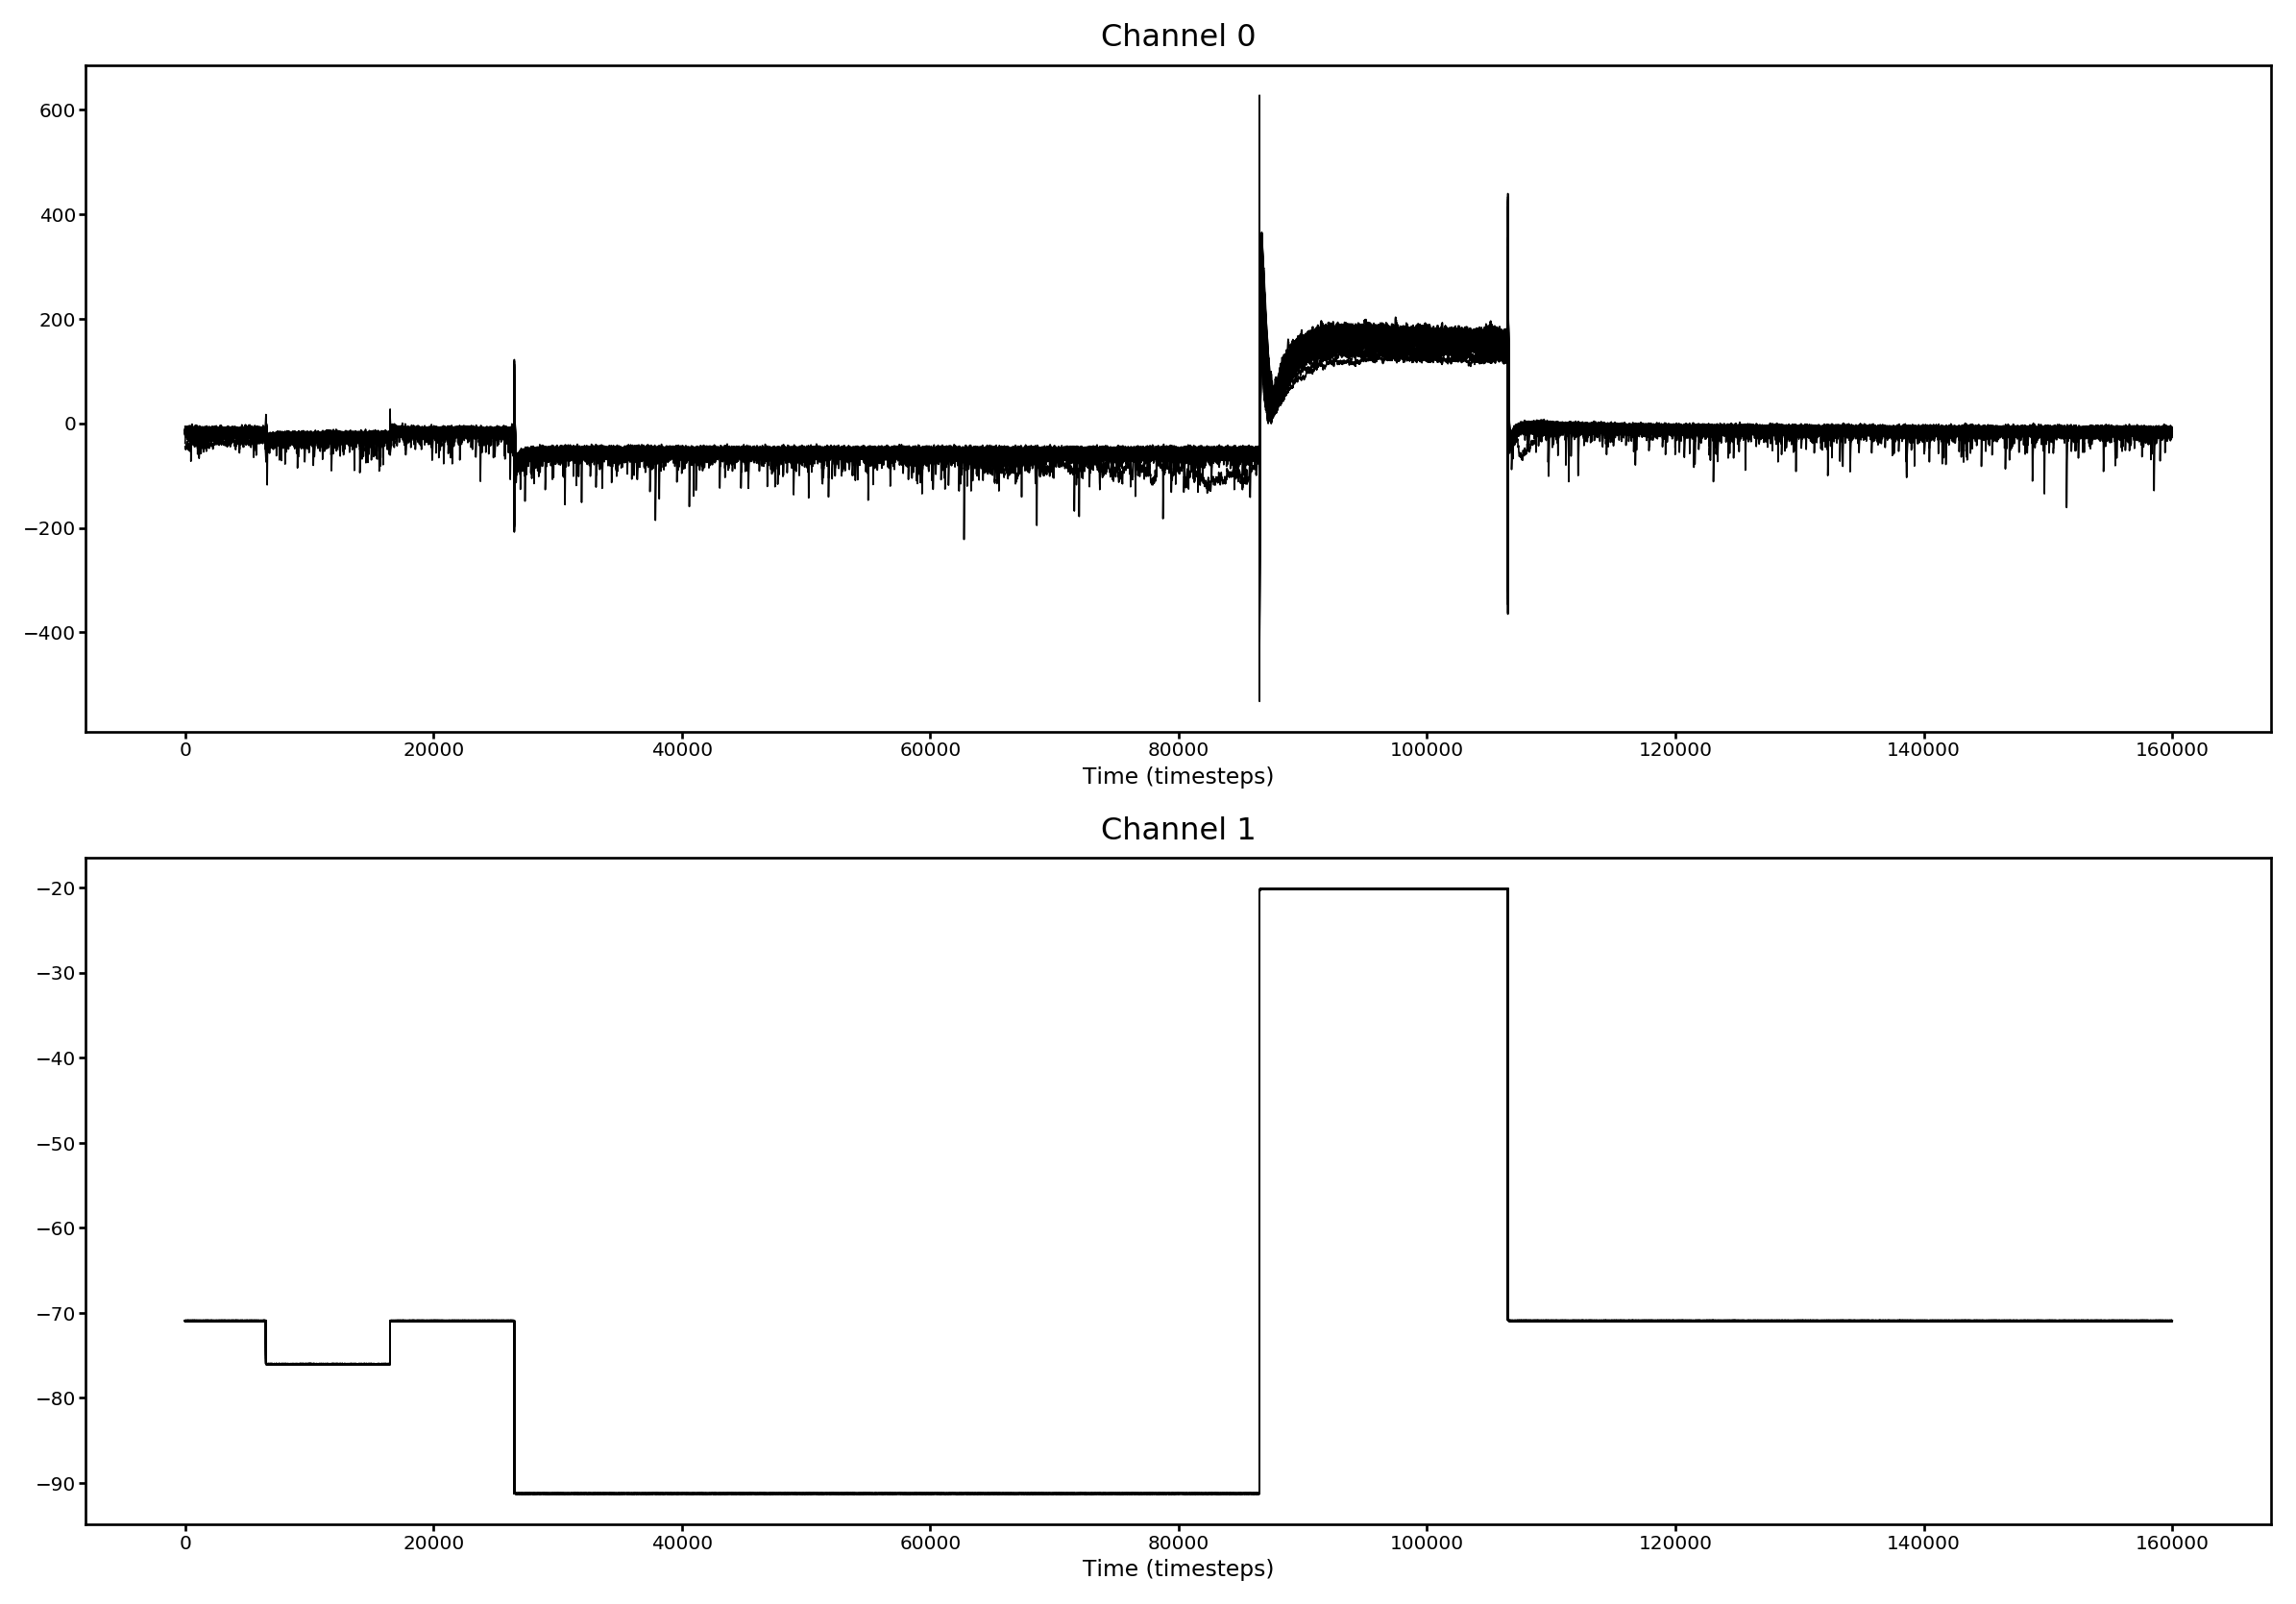

In [10]:
recs = load_recs_by_cell_id('DRN1128')

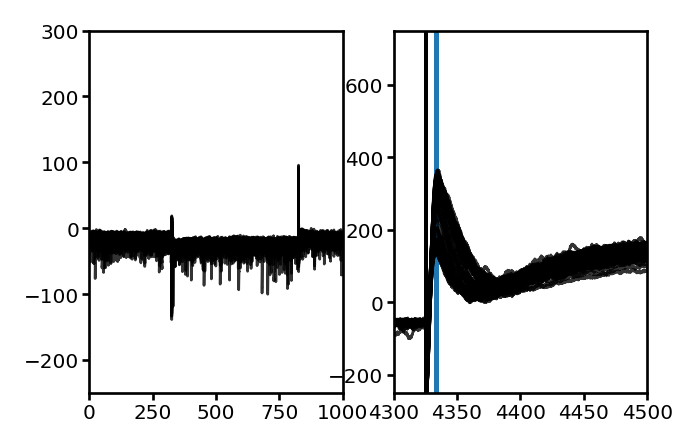

In [11]:
peak_range = np.array([86640, 86720])
time_window_plot(recs, peak_range)

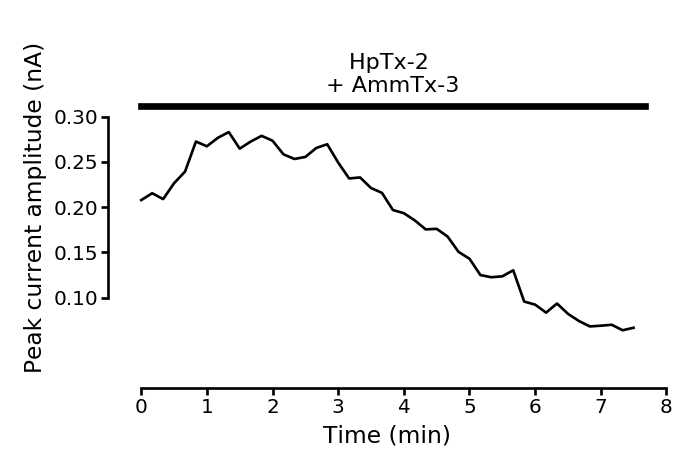

In [12]:
fig, ax = plt.subplots(1, 1)
extract_peak_current(recs, peak_range, 10., ax)
ax.set_ylim(0, 0.4)
ax.set_xlim(-0.5, 8)
plt.savefig(
    os.path.join(
        os.getenv('IMG_PATH'), 
        'ser_ia_pharmacology_heated_time_course_{}'.format('DRN1128')
    )
)
plt.show()
fig.clf()
plt.close(fig)